In [16]:
import pandas as pd
import numpy as np
import sklearn
import nltk
import string 
import matplotlib.pyplot as plt


In [17]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt') 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Giulio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Giulio\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Giulio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
csv_file = 'NewsSentiment.csv'
full_data = pd.read_csv(csv_file)

full_data.head()
full_data['OUTLET'].value_counts()

OUTLET
business insider    5548
WSJ                 3341
NYT                 3326
FT                  3054
guardian            1843
washington post     1753
barrons             1318
google               547
bing                 184
Name: count, dtype: int64

In [19]:
# Will use a subset of whole dataset for the training and testing of the model
# Then will apply the trained model to the whole dataset to generate sentiment scores for all the articles

counts_per_source = {
    'business insider': 5548,
    'WSJ': 3341,
    'NYT': 3326,
    'FT': 3054,
    'guardian': 1843,
    'washington post': 1753,
    'barrons': 1318,
    'google': 547,
    'bing': 184
}

# Percentage of articles to sample from each source
desired_percentage = 0.7

subset_data = pd.DataFrame()

# Sample a percentage of articles from each source
for source, count in counts_per_source.items():
    subset_per_source = full_data[full_data['OUTLET'] == source].sample(
        frac=desired_percentage, random_state=42)
    subset_data = pd.concat([subset_data, subset_per_source])

print(subset_data['OUTLET'].value_counts())

OUTLET
business insider    3884
WSJ                 2339
NYT                 2328
FT                  2138
guardian            1290
washington post     1227
barrons              923
google               383
bing                 129
Name: count, dtype: int64


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

from sklearn.svm import SVR  # SVR for Support Vector Regression
from sklearn.metrics import mean_squared_error, r2_score

import string  

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Define the preprocess_text function
def preprocess_text(text):
    if isinstance(text, str):  # Check if the input is a string
        # Lowercasing
        text = text.lower()

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Tokenization
        tokens = word_tokenize(text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

        # Join tokens back into a string
        processed_text = ' '.join(tokens)

        return processed_text
    else:
        return ''  # Return empty string for missing values


subset_data['processed_text'] = subset_data['TEXT'].apply(preprocess_text)

print("Number of NaN values in 'SENTIMENT' column before handling:")
print(subset_data['SENTIMENT'].isnull().sum())

subset_data.dropna(subset=['SENTIMENT'], inplace=True)

X = subset_data['processed_text']
y = subset_data['SENTIMENT']

# Convert text data to numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize SVM regressor
svm_regressor = SVR(kernel='linear')  # You can choose different kernels

# Train the SVM regressor
svm_regressor.fit(X_train, y_train)

# Predict on the test set
predictions = svm_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")

Number of NaN values in 'SENTIMENT' column before handling:
124
Mean Squared Error: 0.1049
R-squared Score: 0.1855


In [21]:
full_data['processed_text'] = full_data['TEXT'].apply(preprocess_text)

# Separate processed text and labels
X_full = full_data['processed_text']

# Convert text data to numerical features using TF-IDF
X_full_tfidf = tfidf_vectorizer.transform(X_full)

# Predict sentiment for the entire dataset using the trained SVR model
predictions_full = svm_regressor.predict(X_full_tfidf)

In [22]:
full_data['svm_model_predictions'] = predictions_full

print(full_data[['TEXT', 'SENTIMENT', 'svm_model_predictions']].head())

                                                TEXT  SENTIMENT  \
0  Elon Musk has started an electric-vehicle pric...  -0.108693   
1  By James Gordon For Dailymail.com  and Reuters...  -0.151481   
2  By Noa Halff For Dailymail.Com and Associated ...   0.743039   
3  A group of early 2000s PayPal employees and fo...   0.000414   
4  Tesla founder Elon Musk has a biopic on his li...   0.047318   

   svm_model_predictions  
0              -0.008507  
1              -0.121144  
2               0.561299  
3               0.127865  
4              -0.044430  


In [23]:
problematic_dates = []

for date in full_data['DATE']:
    try:
        pd.to_datetime(date, format='%d-%m-%Y')
    except ValueError:
        problematic_dates.append(date)

print("Problematic dates:", problematic_dates)
print(full_data[full_data['DATE'] == '��\x08矤�c\x1e^(>���#X2K���[\x15�*]\x11h3=��;XH8�@=:y��������U��i�nv\x07��qv��b�5Q��D=��:\x1c���\x10Vk�$���{��z����Μ����24\x18��wp9�'])

Problematic dates: ['��\x08矤�c\x1e^(>���#X2K���[\x15�*]\x11h3=��;XH8�@=:y��������U��i�nv\x07��qv��b�5Q��D=��:\x1c���\x10Vk�$���{��z����Μ����24\x18��wp9�']
                                                  DATE OUTLET AUTHOR  \
415  �矤�c^(>���#X2K���[�*]h3=��;XH8�@=:y������...    NaN    NaN   

    DESCRIPTION TEXT  SENTIMENT processed_text  svm_model_predictions  
415         NaN  NaN        NaN                             -0.046761  


In [24]:
full_data['DATE'] = pd.to_datetime(full_data['DATE'], format="%d-%m-%Y", errors='coerce')

full_data = full_data.dropna(subset=['DATE'])

In [25]:
full_data.to_csv('newssentiment_svm_predictions.csv', index=False)

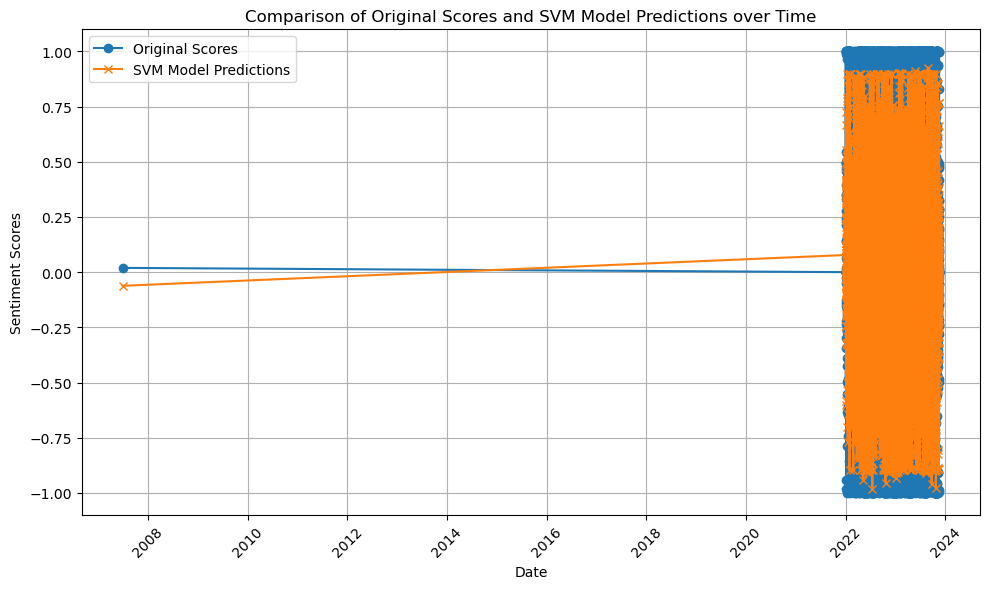

In [26]:
full_data = full_data.sort_values('DATE')

plt.figure(figsize=(10, 6))
plt.plot(full_data['DATE'], full_data['SENTIMENT'], label='Original Scores', marker='o')
plt.plot(full_data['DATE'], full_data['svm_model_predictions'], label='SVM Model Predictions', marker='x')
plt.xlabel('Date')
plt.ylabel('Sentiment Scores')
plt.title('Comparison of Original Scores and SVM Model Predictions over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2023-12-12')

full_data = full_data[(full_data['DATE'] >= start_date) & (full_data['DATE'] <= end_date)]

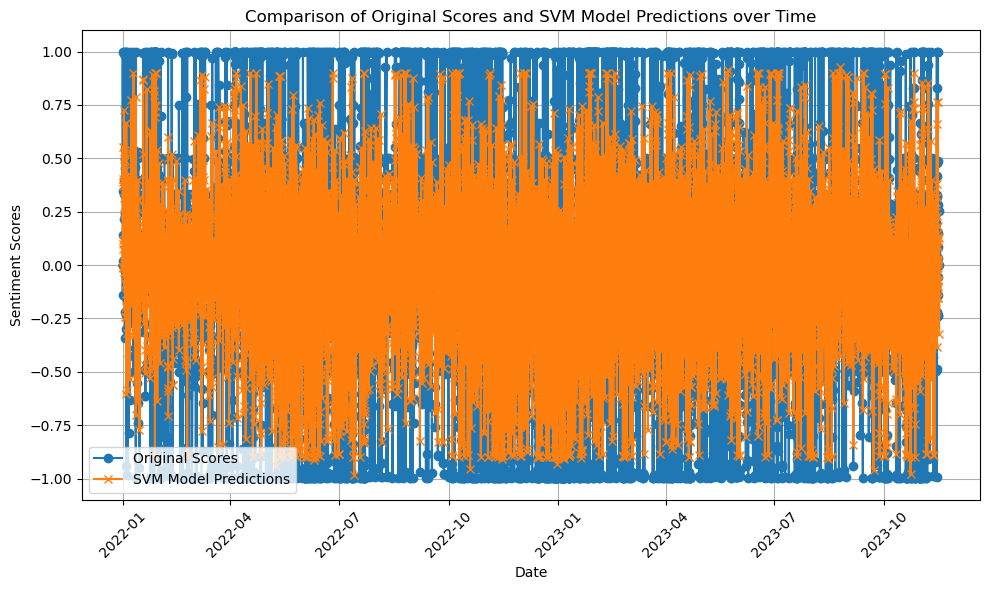

In [28]:
full_data = full_data.sort_values('DATE')

plt.figure(figsize=(10, 6))
plt.plot(full_data['DATE'], full_data['SENTIMENT'], label='Original Scores', marker='o')
plt.plot(full_data['DATE'], full_data['svm_model_predictions'], label='SVM Model Predictions', marker='x')
plt.xlabel('Date')
plt.ylabel('Sentiment Scores')
plt.title('Comparison of Original Scores and SVM Model Predictions over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('svm_sentiment_scores.png')
plt.show()

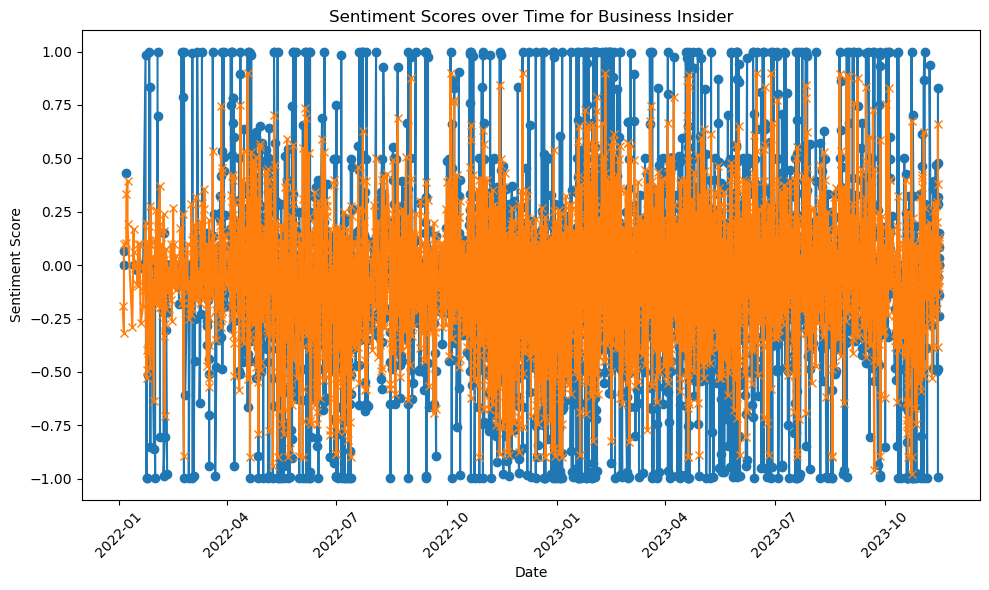

In [29]:
b_i_data = full_data[full_data['OUTLET'] == 'business insider']
# Plot sentiment scores against dates for Business Insider
plt.figure(figsize=(10, 6))
plt.plot(b_i_data['DATE'], b_i_data['SENTIMENT'], marker='o', linestyle='-')
plt.title('Sentiment Scores over Time for Business Insider')
plt.plot(b_i_data['DATE'], b_i_data['svm_model_predictions'], label='SVM Model Predictions', marker='x')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

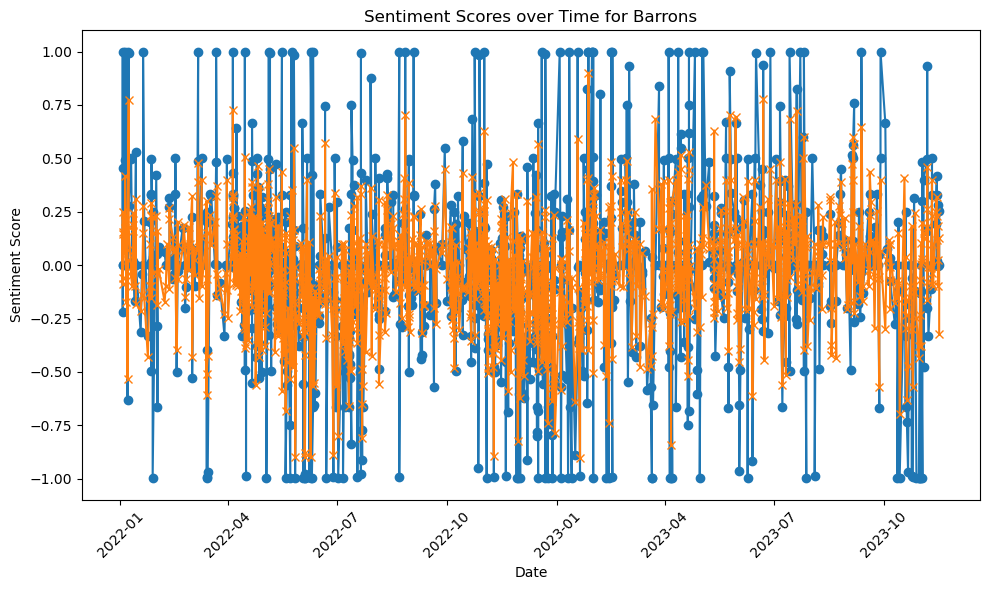

In [31]:
barrons_data = full_data[full_data['OUTLET'] == 'barrons']
# Plot sentiment scores against dates for Barrons
plt.figure(figsize=(10, 6))
plt.plot(barrons_data['DATE'], barrons_data['SENTIMENT'], marker='o', linestyle='-')
plt.title('Sentiment Scores over Time for Barrons')
plt.plot(barrons_data['DATE'], barrons_data['svm_model_predictions'], label='SVM Model Predictions', marker='x')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('svm_sentiment_scores_barrons.png')
plt.show()